# Introduction


This script is written to perform population tests between legacy COMPAS & newCOMPAS data. <br>

It uses .hdf5 data from a legacy run and a newCOMPAS run, and is just a big collection of scripts that then plots distributions and scatter plots based on a large population of binaries. These distributions should largly overlap if the legacy & new COMPAS are supposed to do the same thing :-) <br>


input should be: <br>
1. legacy COMPAS.h5 output file (which is automatically created when you run legacyCOMPAS through compas_hpc.py
2. newCOMPAS.h5 output file. newCOMPAS creates .csv files. But in the folder COMPAS/postProcessing/1_H5/ you can find the file 1_combineCSVtoH5.ipynb which will rewrite it to a hdf5 format <br>



 please feel free to add/change things. 

# imports

In [1]:
from __future__ import print_function
# from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
minor = AutoMinorLocator()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Custom imports

In [2]:
import sys

sys.path.append('/Users/floorbroekgaarden/Programs/COMPAS/popsynth/Papers/BroekgaardenEtAl/black_hole-neutron_star/Scripts')
# import coencodeVarious as CV
# import ClassCOMPAS     as CC
# import ClassFormationChannels as FC
# from PostProcessingScripts import * 


# Read in the data

In [40]:
#general path to file (which I pass to the formationChannel file later)
path = '/Users/floorbroekgaarden/Programs/COMPAS/popsynth/Papers/BroekgaardenEtAl/tests_Legacy_vs_NEW_COMPAS/DATA_test_0/'
pathCOMPASOutput = '/Users/floorbroekgaarden/Programs/COMPAS/popsynth/Papers/BroekgaardenEtAl/tests_Legacy_vs_NEW_COMPAS/DATA_test_0/'
#specific path to use now
path_new = path+'COMPASOutput_newCOMPAS.h5'
path_legacy  = path+'COMPASOutput_oldCOMPAS.h5'

fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)

COMPASv = '02.04.02'

print(fdata_new.keys())
print()
print(fdata_new['DoubleCompactObjects'].keys())

<KeysViewHDF5 ['CommonEnvelopes', 'DoubleCompactObjects', 'RLOF', 'Supernovae', 'SystemParameters']>

<KeysViewHDF5 ['Binding_Energy@CE_1', 'Binding_Energy@CE_2', 'CEE', 'CE_Alpha', 'Coalescence_Time', 'Double_Core_CE', 'Eccentricity<2ndSN', 'Eccentricity<CE', 'Eccentricity>CE', 'Eccentricity@DCO', 'Eccentricity_0', 'Experienced_SN_Type_1', 'Experienced_SN_Type_2', 'ID', 'Kick_Velocity_1', 'Kick_Velocity_2', 'LBV_Multiplier', 'Lambda@CE_1', 'Lambda@CE_2', 'MT_Case_1', 'MT_Case_2', 'MZAMS_1', 'MZAMS_2', 'Mass_0_1', 'Mass_0_2', 'Mass_1', 'Mass_2', 'Mass_CO_Core@CE_1', 'Mass_CO_Core@CE_2', 'Mass_CO_Core@CO_1', 'Mass_CO_Core@CO_2', 'Mass_Core@CE_1', 'Mass_Core@CE_2', 'Mass_Core@CO_1', 'Mass_Core@CO_2', 'Mass_He_Core@CE_1', 'Mass_He_Core@CE_2', 'Mass_He_Core@CO_1', 'Mass_He_Core@CO_2', 'Mass_Total@CO_1', 'Mass_Total@CO_2', 'Merges_Hubble_Time', 'Metallicity_1', 'Metallicity_2', 'Optimistic_CE', 'Orb_Velocity<2ndSN', 'Orbital_Energy<SN_1', 'Orbital_Energy<SN_2', 'Orbital_Energy>SN_1', 'Orbit

In [31]:
#Note above that COMPASOutput.h5 contains all the ascii files
#(if turned on in the pythonSubmit during the simulation)

#easy name for the doubleCompactObjects h5 group


In [4]:
#chosenMetallicity= 0.001



# fDCO  = fdata['doubleCompactObjects']
# fForm = fdata['formationChannels']
# fSN   = fdata['supernovae']
# fCE  = fdata['commonEnvelopes']

# totalSystems= len((fdata['systems']['mass1'][...].squeeze()))
# print(totalSystems, 'total systems simulated')
# #Only want BBHs



# info about metallicities

# general function for given specific metallicity: 


# General Plots

In [4]:
class LegacyVSnewCOMPAS(object):

    
    
    def __init__(self, hdf5, whichCOMPAS, metallicity, DCOtype, boolDCOmask):
        """
        fxparam  is hdf5 keyname of file where variable for which you want to mask DCOs is in 
        DCOtype = 'BBH' / 'ALL' / 'BHNS' or 'BNS' 
        boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
        binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
        pathToDirectory is pathname to Directory where _oratory & _sampling directories are        
        """
        self.hdf5 = hdf5  # 
        self.model = whichCOMPAS
        self.metallicity = metallicity
        self.DCOtype = DCOtype
        self.boolDCOmask = boolDCOmask

        if self.model=='legacy':
            self.fDCO  = self.hdf5['doubleCompactObjects']
            self.fForm = self.hdf5['formationChannels']
            self.fSN   = self.hdf5['supernovae']
            self.fCE  = self.hdf5['commonEnvelopes']
            self.fSystems = self.hdf5['systems']
            self.totalSystems= len((self.hdf5['systems']['mass1'][...].squeeze()))
            
        elif self.model=='new':
            self.fDCO  = self.hdf5['DoubleCompactObjects']
#             self.fForm = self.hdf5['formationChannels']
            self.fSN   = self.hdf5['Supernovae']
            self.fCE  = self.hdf5['CommonEnvelopes']
            self.fSystems = self.hdf5['SystemParameters']
            
            self.totalSystems= len((self.hdf5['SystemParameters']['MZAMS_1'][...].squeeze()))

            
        
        
    def obtainData(self, param):
        """returns for STROOPWAFEL (AIS) simulation the data of wanted variable
        combines the data from AIS_oratory and AIS_sampling 

        param = [xparam, fxparam] ,  are the name of the variable and hdf5 keyname where it is in
        e.g. param = ['M1', 'doubleCompactObjects'] (see also: print(list(f.keys())))
        pathToDirectory is pathname to Directory where AIS_oratory & AIS_sampling directories are
        """ 

        xparam, fxparam = param

  

        fAIS = self.hdf5
    
        

        ##### get parameter from two directories and combine them ############
        xvalues         = fAIS[fxparam][xparam][...].squeeze()
        return   xvalues



    def maskTarget(self, otherSelection=None, otherparam=None):
        """returns mask of DCOs of interest

        """

        Hubble, RLOF, Pessimistic = self.boolDCOmask

            
            
        if self.model=='legacy':
            # mask binaries of given DCO type
            if self.DCOtype == 'BNS':
                mask0 = ((self.fDCO['stellarType1'][...] == 13) & (self.fDCO['stellarType2'][...] == 13))
            elif (self.DCOtype == 'BHNS') | (self.DCOtype == 'NSBH'):
                mask0 = ((self.fDCO['stellarType1'][...] == 13) & (self.fDCO['stellarType2'][...] == 14)) | \
                    ((self.fDCO['stellarType1'][...] == 14) & (self.fDCO['stellarType2'][...] == 13) )          
            elif self.DCOtype == 'BBH':
                mask0 = ((self.fDCO['stellarType1'][...] == 14) & (self.fDCO['stellarType2'][...] == 14))
            elif (self.DCOtype == 'all') | (self.DCOtype == 'ALL') :
                mask0 = ((self.fDCO['stellarType1'][...] == 14) | (self.fDCO['stellarType1'][...] == 13))
            else:
                print('error: DCO type not known')

            # Hubble mask
            if Hubble:
                mask1 = (self.fDCO['mergesInHubbleTimeFlag'][...]==True) 
            elif not Hubble:
                mask1 = (self.fDCO['mergesInHubbleTimeFlag'][...]==True) |  (self.fDCO['mergesInHubbleTimeFlag'][...]==False) 
            # RLOF mask
            if RLOF:
                mask2 = (self.fDCO['RLOFSecondaryAfterCEE'][...]==False)
            elif not RLOF:
                mask2 = (self.fDCO['RLOFSecondaryAfterCEE'][...]==False) | (self.fDCO['RLOFSecondaryAfterCEE'][...]==True)
            # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
            if Pessimistic:
                mask3 = np.logical_not(self.fDCO["optimisticCEFlag"][...] == 1)
            elif not Pessimistic:
                mask3 = np.logical_not(self.fDCO["optimisticCEFlag"][...] == 1) + \
                np.logical_not(self.fDCO["optimisticCEFlag"][...] == 0)   
                
        if self.model=='new':
            # mask binaries of given DCO type
            if self.DCOtype == 'BNS':
                mask0 = ((self.fDCO['Stellar_Type_1'][...] == 13) & (self.fDCO['Stellar_Type_2'][...] == 13))
            elif (self.DCOtype == 'BHNS') | (self.DCOtype == 'NSBH'):
                mask0 = ((self.fDCO['Stellar_Type_1'][...] == 13) & (self.fDCO['Stellar_Type_2'][...] == 14)) | \
                    ((self.fDCO['Stellar_Type_1'][...] == 14) & (self.fDCO['Stellar_Type_2'][...] == 13) )          
            elif self.DCOtype == 'BBH':
                mask0 = ((self.fDCO['Stellar_Type_1'][...] == 14) & (self.fDCO['Stellar_Type_2'][...] == 14))
            elif (self.DCOtype == 'all') | (self.DCOtype == 'ALL') :
                mask0 = ((self.fDCO['Stellar_Type_1'][...] == 14) | (self.fDCO['Stellar_Type_1'][...] == 13))
            else:
                print('error: DCO type not known')

            # Hubble mask
            if Hubble:
                mask1 = (self.fDCO['Merges_Hubble_Time'][...]==True) 
            elif not Hubble:
                mask1 = (self.fDCO['Merges_Hubble_Time'][...]==True) |  (self.fDCO['Merges_Hubble_Time'][...]==False) 
            # RLOF mask
            if RLOF:
                mask2 = (self.fDCO['RLOF_Secondary>CE'][...]==False)
            elif not RLOF:
                mask2 = (self.fDCO['RLOF_Secondary>CE'][...]==False) | (self.fDCO['RLOF_Secondary>CE'][...]==True)
            # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
            if Pessimistic:
                mask3 = np.logical_not(self.fDCO["Optimistic_CE"][...] == 1)
            elif not Pessimistic:
                mask3 = np.logical_not(self.fDCO["Optimistic_CE"][...] == 1) + \
                np.logical_not(self.fDCO["Optimistic_CE"][...] == 0)   

                
                
        print('mask sums = ',  np.sum(mask0), np.sum(mask1), np.sum(mask2), np.sum(mask3))
        # combine the different masks and the oratory and refinement masks
        combinedmask = mask0 * mask1 * mask2 * mask3
        combinedmask = combinedmask.squeeze()
        if otherSelection =='UFD':
            KpcToKM = 3.086 * 10**(16) # kpc to km  
            MyrToYr = 1E6 # yrs
            YrToSec = 3.154 *1E7 #sec        
            UFD_epsilon = otherparam[0]
            UFD_Rvir = otherparam[1]
            Xbh1 = otherparam[2]
            Rns = otherparam[3]

            fSN = f['supernovae']
            seedsOfIntererst = fDCO['seed'][...].squeeze()
            seedsSN = fSN['randomSeed'][...].squeeze()
            bools = np.in1d(seedsSN, seedsOfIntererst)        

            tc  = fDCO['tc'][...].squeeze()
            vsys = fSN['systemicVelocity'][...].squeeze()[bools]
            vsysSN2 = vsys[1:][::2]
            traveldistance = tc * vsysSN2 *  MyrToYr * YrToSec
            radiusUFDgalaxy = UFD_epsilon * UFD_Rvir * KpcToKM
            maskCandidatesUFD = (traveldistance <= radiusUFDgalaxy) | ((vsysSN2 <= 44) & (tc * MyrToYr *YrToSec<= radiusUFDgalaxy)) 

            combinedmask = maskCandidatesUFD*combinedmask



        return combinedmask


    def BHNSorNSBH(m1bh, m2bh):
        # add later on the 2nd explodes first 

        maskBHNS = m1bh >= m2bh # we have a BH=NS


        return maskBHNS

    def below3Msun(m1bh):
        # add later on the 2nd explodes first 

        maskBHNS = m1bh <= 3 # we have a BH=NS


        return maskBHNS



    def obtainweights(self):
        """returns weights for all DCOs and all systems for STROOPWAFEL
        pathToDirectory is pathname to Directory where AIS_oratory & AIS_sampling directories are 
        """

        if self.model=='legacy':
            
            DCOsweights          = np.ones(len(self.fDCO['weight'][...].squeeze()))
            systemsweights          = np.ones(len(self.fSystems['weight'][...].squeeze() ))           
            
            
#             ##### get the DCO and all system weights  ############
#             DCOsweights          = self.fDCO['weight'][...].squeeze()
#             systemsweights          = self.fSystems['weight'][...].squeeze()

        elif self.model=='new':
            systemsweights = np.ones(self.totalSystems)
            DCOsweights =  np.ones(len((self.fDCO['SEED'][...].squeeze())))

        return DCOsweights, systemsweights


    def chirpmass(m1, m2):
        numer = (m1*m2)**(3/5)
        denom = (m1+m2)**(1/5)

        return numer/denom




    def obtainM1BHandM2BHassymetric(m1, m2):
        m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
        maskm1heavier = ( m1 >= m2)
        maskm2heavier = (m1 < m2)

        m1bh[maskm1heavier] = m1[maskm1heavier] 
        m1bh[maskm2heavier] = m2[maskm2heavier]
        m2bh[maskm1heavier] = m2[maskm1heavier]
        m2bh[maskm2heavier] = m1[maskm2heavier]

        return m1bh, m2bh # m1bh has all the heaviest systems



        
        
    def getvariables(self, var_x, var_y):
        '''
        var_x = name of x variable we want to get (has to live in DCO file)
        var_y = name of y variable we want to get (has to live in DCO file)
        model = name of directory with data specific model e.g. Fiducial/
        DCOtype = 'BHNS' or ('BBH', 'BNS', 'ALL')
        boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
        binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
        '''


        if self.model=='legacy':


            


            if self.metallicity:
                # mask specific requested metallicity  
                maskDCO_temp = self.maskTargetDCOsSTROOPWAFEL(self,\
                                                    otherSelection=None, otherparam=None) 
                maskDCO = (self.fDCO['Metallicity1'][...].squeeze() == self.metallicity) & (maskDCO_temp == 1)

            else:
                #Only want selected DCO type (combines all metallicities & does not mask specific metallicity)
                maskDCO = self.maskTargetDCOsSTROOPWAFEL(self,\
                                                    otherSelection=None, otherparam=None)


            #what are the seeds of the systems that form BBHs
#             seedsOfIntererst = self.fDCO['seed'][...].squeeze()[maskDCO]
            #Give me a bool of the lines in formation channels that form BBHs
#             bools = np.in1d(fForm['m_randomSeed'][...].squeeze(),seedsOfIntererst)
            weightsSystems =  self.hdf5['systems']['weight'][...].squeeze()
            totalSystems = np.sum(self.hdf5['systems']['weight'][...].squeeze()) # total weight of DCOs of interest
            totalSystemsDCO = np.sum(fDCO['weight'][...].squeeze()[maskDCO])



            #Because I dont want to retype the columns every time and I dont want 
            #all the data 
            metallicities    = np.log10((fDCO['Metallicity1'][...][maskDCO].squeeze())/0.0142)
            varx             = fDCO[var_x][...][maskDCO].squeeze()
            vary             = fDCO[var_y][...][maskDCO].squeeze()


        # legacy COMPAS 
        elif self.model=='new':


            if self.metallicity:
                # mask specific requested metallicity  
                maskDCO_temp = self.maskTargetDCOsSTROOPWAFEL(self,\
                                                    otherSelection=None, otherparam=None) 
                maskDCO = (self.fDCO['Metallicity1'][...].squeeze() == self.metallicity) & (maskDCO_temp == 1)

            else:
                #Only want selected DCO type (combines all metallicities & does not mask specific metallicity)
                maskDCO = self.maskTargetDCOsSTROOPWAFEL(self,\
                                                    otherSelection=None, otherparam=None)


            #what are the seeds of the systems that form BBHs
#             seedsOfIntererst = fDCO['SEED'][...].squeeze()[maskDCO]
            #Give me a bool of the lines in formation channels that form BBHs
#             bools = np.in1d(fForm['m_randomSeed'][...].squeeze(),seedsOfIntererst)
            weightsSystems =  self.hdf5['systems']['weight'][...].squeeze()
            totalSystems = np.sum(self.hdf5['systems']['weight'][...].squeeze()) # total weight of DCOs of interest
            totalSystemsDCO = np.sum(fDCO['weight'][...].squeeze()[maskDCO])



            #Because I dont want to retype the columns every time and I dont want 
            #all the data 
#             metallicities    = np.log10((fDCO['Metallicity1'][...][maskDCO].squeeze())/0.0142)
            varx             = self.fDCO[var_x][...][maskDCO].squeeze()
            vary             = self.fDCO[var_y][...][maskDCO].squeeze()



        return varx, vary








    
    


In [5]:
print('--------------- LEGACY ------------------------')
print(fdata_legacy.keys())
print()
print(fdata_legacy['supernovae'].keys())
print()
print()

#################
print('---------------- NEW -----------------------')
print(fdata_new.keys())
print()
print(fdata_new['DoubleCompactObjects'].keys())


--------------- LEGACY ------------------------
<KeysViewHDF5 ['RLOF', 'XRayBinaries', 'commonEnvelopes', 'cppSource', 'doubleCompactObjects', 'formationChannels', 'pulsarEvolution', 'runtimes', 'supernovae', 'systems']>

<KeysViewHDF5 ['MCompanionZAMS', 'MSNZAMS', 'MassCOCoreSN', 'MassCoreSN', 'MassStarCompanion', 'MassStarSN', 'Metallicity', 'Mrem', 'RemnantType', 'Survived', 'commonEnvelopeOccuredAtLeastOnce', 'drawnKickVelocity', 'eccentricityAfter', 'eccentricityBefore', 'experiencedRLOF', 'fallback', 'flagECSN', 'flagHpoorSN', 'flagHrichSN', 'flagPISN', 'flagPPISN', 'flagRLOFontoaNS', 'flagSN', 'flagUSSN', 'kickVelocity', 'm_stableRLOFafterCEE', 'phi', 'previousStellarTypeCompanion', 'previousStellarTypeSN', 'psi', 'randomSeed', 'runawayFlag', 'separationAfter', 'separationBefore', 'systemicVelocity', 'theta', 'time', 'uK', 'vRel', 'whichStar']>


---------------- NEW -----------------------
<KeysViewHDF5 ['CommonEnvelopes', 'DoubleCompactObjects', 'RLOF', 'Supernovae', 'SystemPa

In [6]:
def plotLegacyVSnewCOMPAS(xyw_legacy, xyw_new, xyl_label, xylim, plotname):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    fs = 20
    
    
    xparam = [xyw_legacy[0], xyw_new[0]]
    yparam = [xyw_legacy[1], xyw_new[1]]
    weights= [xyw_legacy[2], xyw_new[2]]

    
    xlabel, ylabel, legendlabel = xyl_label
    titles = ['LEGACY', 'NEW']
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    
    
    
    f, ax= plt.subplots(ncols=2, nrows=2, figsize=(16,16)) #,   gridspec_kw={"width_ratios":[1.5, 1.5]}




    
    
    
    for z_ind in range(2):
        

        colorr = ['m', 'b']

        ax[0, z_ind].scatter(xparam[z_ind], yparam[z_ind], s=weights[z_ind]*10 , edgecolor ='k', linewidth=0.1,\
                         c=colorr[z_ind], label =legendlabel, zorder=10)




        ax[0, z_ind].set_ylabel(ylabel, fontsize=fs)
        ax[0, z_ind].set_xlabel(xlabel, fontsize=fs)
        ax[0, z_ind].set_title(titles[z_ind], fontsize=fs+10)
        ax[0, z_ind].legend(fontsize=fs)

        ax[0, z_ind].tick_params(labelsize=fs)
        ax[0, z_ind].grid(True, which='major');
        
        if xylim:
            ax[0, z_ind].set_xlim(xylim[0][0], xylim[0][1])
            ax[0, z_ind].set_ylim(xylim[1][0], xylim[1][1])


            

        bins = 30
        
        ####################   
        #### X param hist # 
        if z_ind==0:
            if xylim:
                bins = np.linspace(xylim[0][0], xylim[0][1], 40)
                ax[1, z_ind].set_xlim(xylim[0][0], xylim[0][1])

            ax[1, z_ind].hist(xparam[0], bins=bins, density=True,\
                             color=colorr[0], zorder=10, alpha=0.6, label=titles[0])
            ax[1, z_ind].hist(xparam[1], bins=bins, histtype='step', density=True,\
                             color=colorr[1], zorder=20, alpha=1, lw=4, label=titles[1])
            
            
            ax[1, z_ind].legend(fontsize=fs)
            ax[1, z_ind].set_ylabel('PDF', fontsize=fs)
            ax[1, z_ind].set_xlabel(xlabel, fontsize=fs)
            ax[1, z_ind].tick_params(labelsize=fs)
            ax[1, z_ind].grid(True, which='major');
        
            

            
        if z_ind==1:
            ####################   
            #### Y param hist # 
            if xylim:
                bins =  np.linspace(xylim[1][0], xylim[1][1], 40)
                ax[1, z_ind].set_xlim(xylim[1][0], xylim[1][1])

            ax[1, z_ind].hist(yparam[0], bins=bins, density=True,\
                             color=colorr[0], zorder=10, alpha=0.6)
            ax[1, z_ind].hist(yparam[1], bins=bins, histtype='step', density=True,\
                             color=colorr[1], zorder=20, alpha=1, lw=4)
            
            
            ax[1, z_ind].set_ylabel('PDF', fontsize=fs)
            ax[1, z_ind].set_xlabel(ylabel, fontsize=fs)
            ax[1, z_ind].tick_params(labelsize=fs)
            ax[1, z_ind].grid(True, which='major');
        
        

        

            
    f.tight_layout()
    f.savefig('./images/'+ plotname +'.png') #, bbox_extra_artists=(lgd,), bbox_inches='tight'
    plt.show()
    plt.close() 
        
        
    return 



# CHECK SYSTEM PARAMETERS

In [7]:
print('--------------- LEGACY ------------------------')
print(fdata_legacy.keys())
print()
print(fdata_legacy['systems'].keys())
print()
print()

#################
print('---------------- NEW -----------------------')
print(fdata_new.keys())
print()
print(fdata_new['SystemParameters'].keys())



--------------- LEGACY ------------------------
<KeysViewHDF5 ['RLOF', 'XRayBinaries', 'commonEnvelopes', 'cppSource', 'doubleCompactObjects', 'formationChannels', 'pulsarEvolution', 'runtimes', 'supernovae', 'systems']>

<KeysViewHDF5 ['CE_Alpha', 'ID', 'LBV_multiplier', 'Metallicity1', 'Metallicity2', 'S1type_final', 'S2type_final', 'SEED', 'WR_multiplier', 'disbound', 'eccentricity', 'errorFlag', 'mass1', 'mass2', 'meanAnomaly1', 'meanAnomaly2', 'omega1', 'omega2', 'phi1', 'phi2', 'rk1', 'rk2', 'samplingPhase', 'separation', 'sigma_kick_CCSN_BH', 'sigma_kick_CCSN_NS', 'sigma_kick_ECSN', 'sigma_kick_USSN', 'stellar_merger', 'theta1', 'theta2', 'weight']>


---------------- NEW -----------------------
<KeysViewHDF5 ['CommonEnvelopes', 'DoubleCompactObjects', 'RLOF', 'Supernovae', 'SystemParameters']>

<KeysViewHDF5 ['CE_Alpha', 'Eccentricity_0', 'Error', 'ID', 'LBV_Multiplier', 'MZAMS_1', 'MZAMS_2', 'Mass_0_1', 'Mass_0_2', 'Mean_Anomaly_1', 'Mean_Anomaly_2', 'Merger', 'Merger_At_Birth

# INITIAL CONDITIONS

No handles with labels found to put in legend.
No handles with labels found to put in legend.


FileNotFoundError: [Errno 2] No such file or directory: './images/ZAMS_qSystemParameters_Z0.001__compas_02.03.05.png'

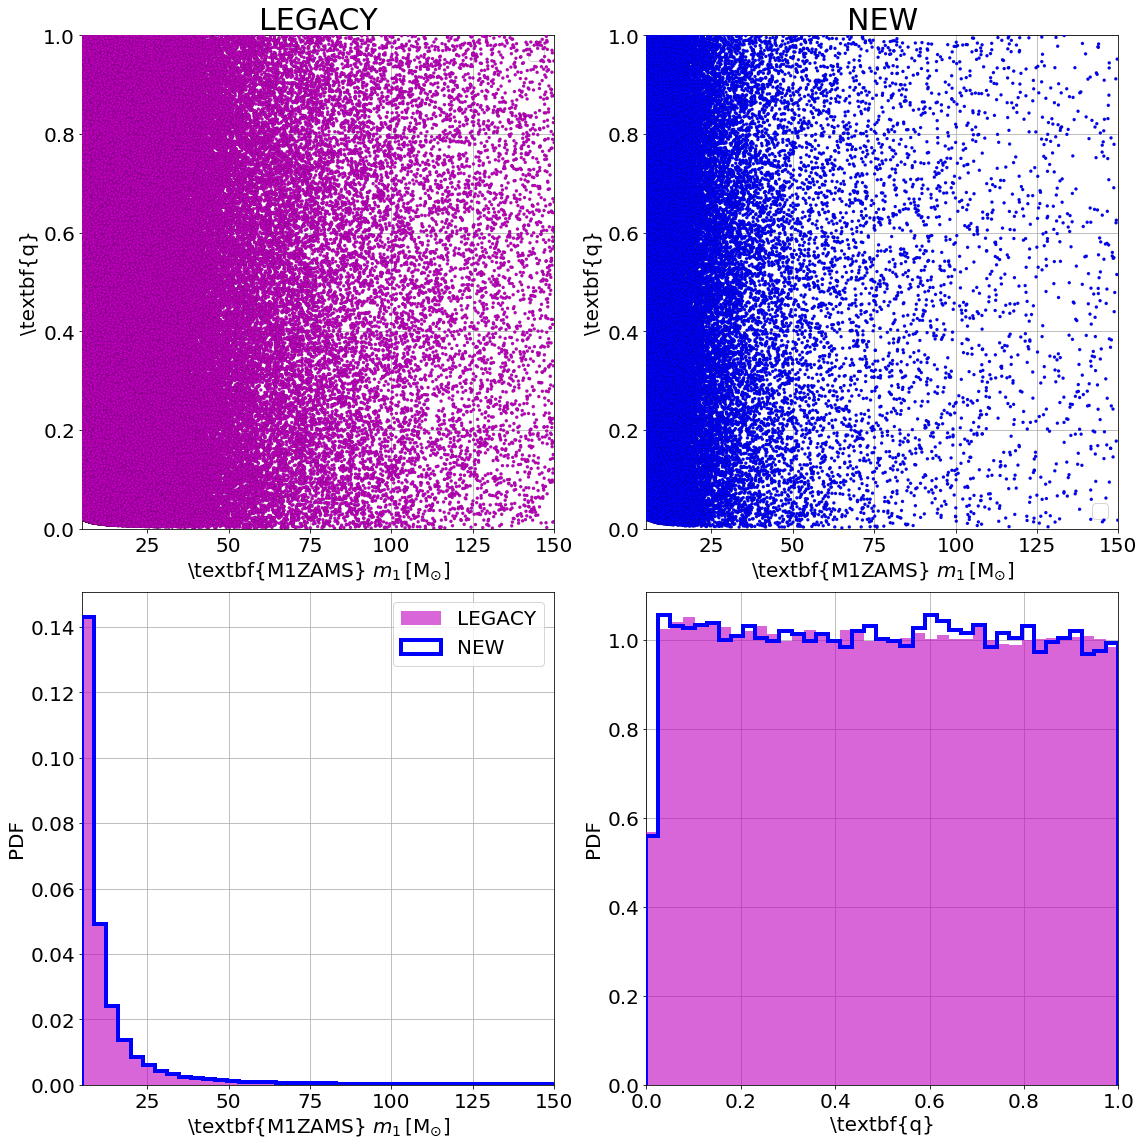

In [8]:


fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)

xvar_leg, yvar_leg = LEG.obtainData(param=['mass1','systems']), LEG.obtainData(param=['mass2','systems'])
# DCOmask_leg = LEG.maskTarget(otherSelection=None, otherparam=None)
DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','SystemParameters'


xvar_new, yvar_new = NEW.obtainData(param=['MZAMS_1',fparam]), NEW.obtainData(param=['MZAMS_2',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
DCOweights_new, SystemWeights_new = NEW.obtainweights()




# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'\textbf{M1ZAMS} $m_{1} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{q}'
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg, yvar_leg/xvar_leg, SystemWeights_leg]
xyw_newCOMPAS    = [xvar_new, yvar_new/xvar_new, SystemWeights_new]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[5,150], [0,1]]
# xylim= None
COMPASv = '02.03.05'
pltname = 'ZAMS_q' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)





No handles with labels found to put in legend.
No handles with labels found to put in legend.


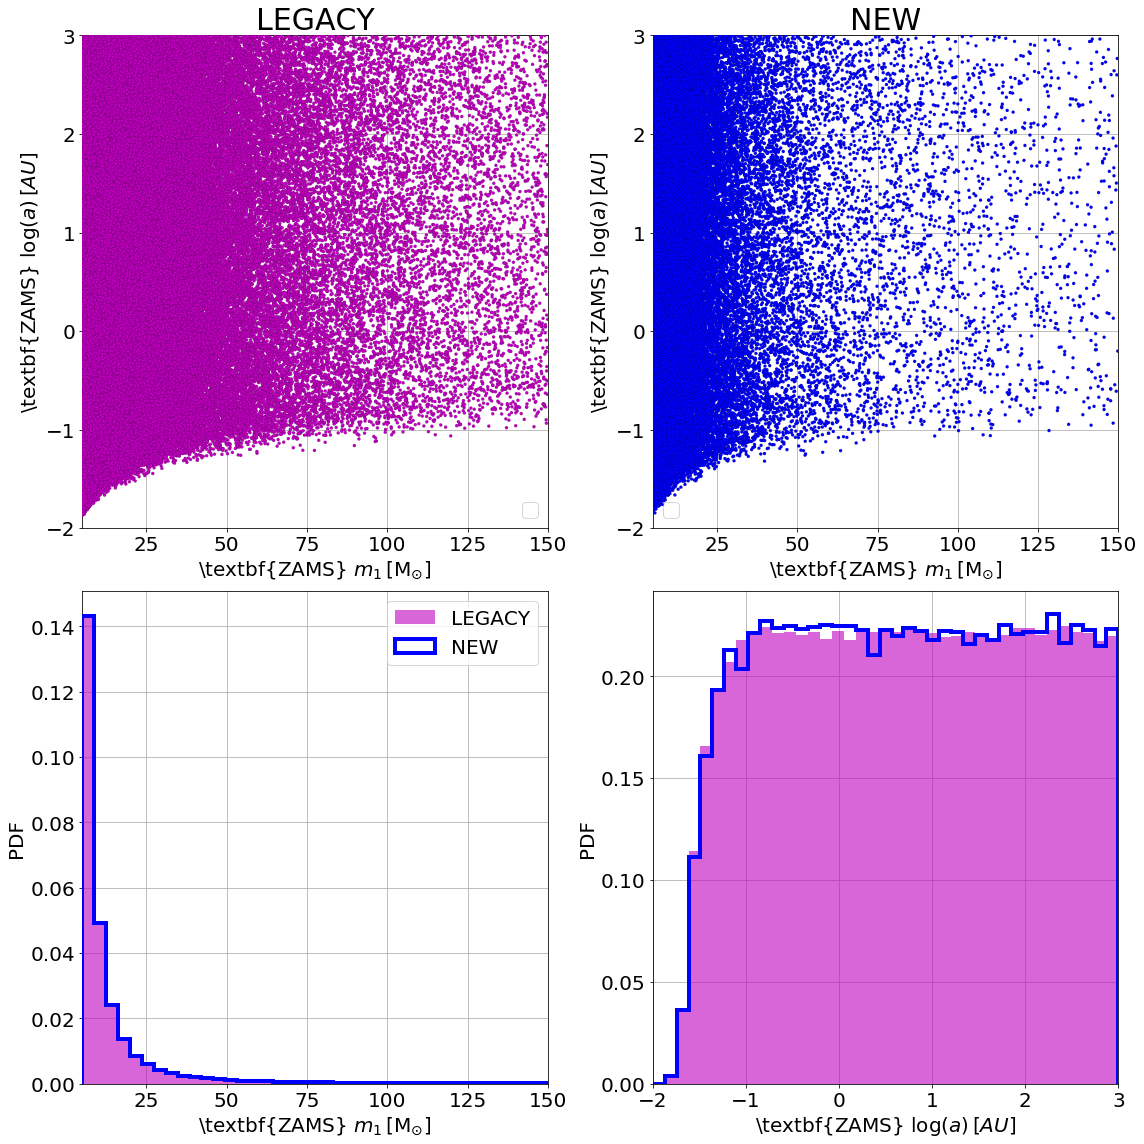

In [9]:


fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)

xvar_leg, yvar_leg = LEG.obtainData(param=['mass1','systems']), LEG.obtainData(param=['separation','systems'])
# DCOmask_leg = LEG.maskTarget(otherSelection=None, otherparam=None)
DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','SystemParameters'


xvar_new, yvar_new = NEW.obtainData(param=['MZAMS_1',fparam]), NEW.obtainData(param=['Separation',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
DCOweights_new, SystemWeights_new = NEW.obtainweights()




# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'\textbf{ZAMS} $m_{1} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{ZAMS} $\log(a) \, [AU]$' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg, np.log10(yvar_leg), SystemWeights_leg]
xyw_newCOMPAS    = [xvar_new, np.log10(yvar_new), SystemWeights_new]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[5,150], [-2,3]]
# xylim= None
COMPASv = '02.03.05'
pltname = 'm1VSa_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)






# SUPERNOVA

No handles with labels found to put in legend.
No handles with labels found to put in legend.


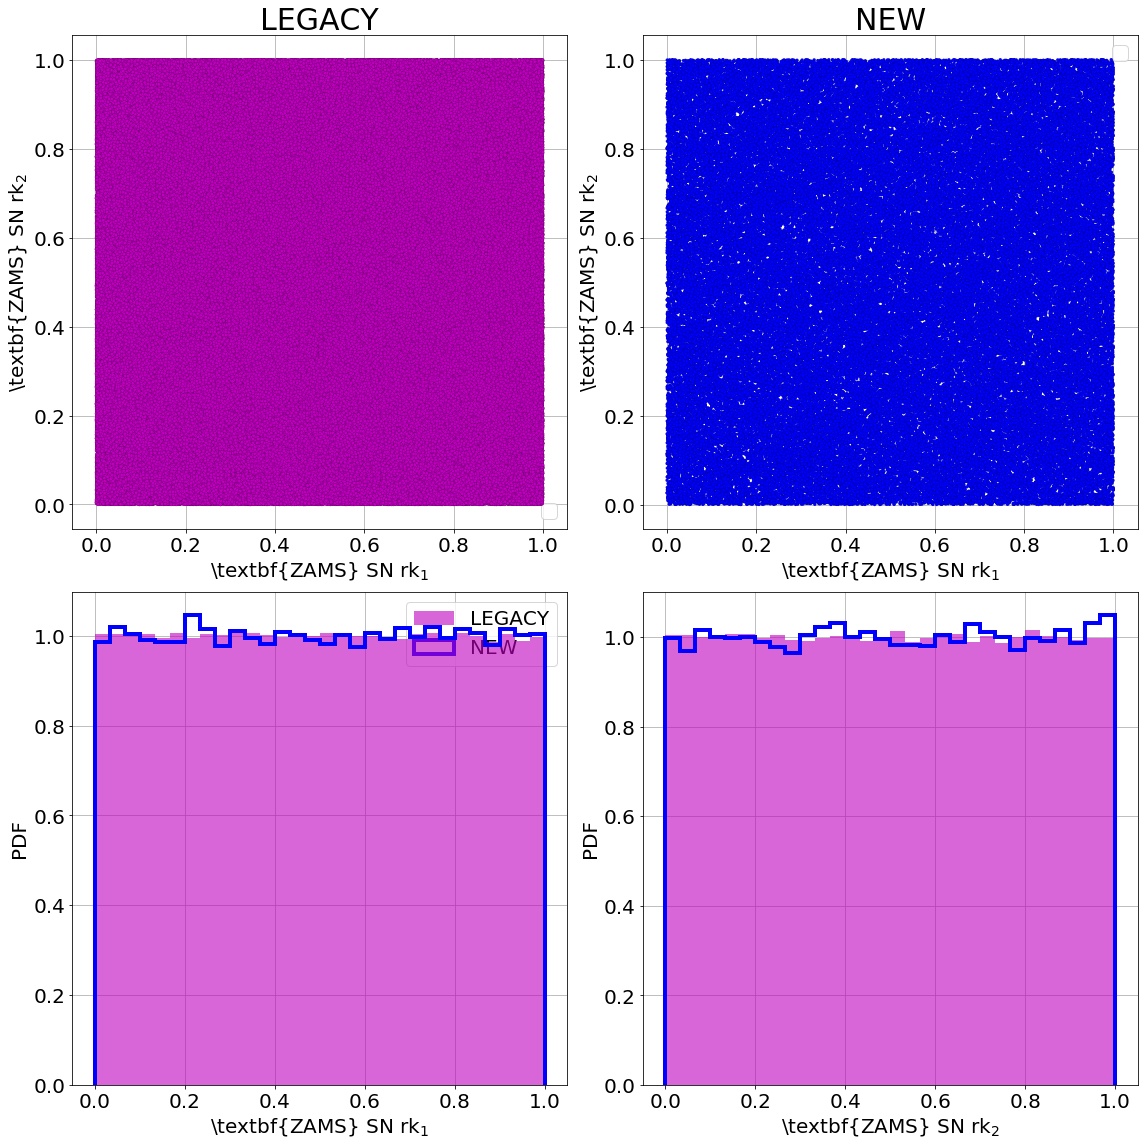

In [10]:


fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)

xvar_leg, yvar_leg = LEG.obtainData(param=['rk1','systems']), LEG.obtainData(param=['rk2','systems'])
# DCOmask_leg = LEG.maskTarget(otherSelection=None, otherparam=None)
DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','SystemParameters'


xvar_new, yvar_new = NEW.obtainData(param=['SN_Kick_VM_Rand_1',fparam]), NEW.obtainData(param=['SN_Kick_VM_Rand_2',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
DCOweights_new, SystemWeights_new = NEW.obtainweights()




# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'\textbf{ZAMS} SN $\rm{rk}_1 $'
ylabel = r'\textbf{ZAMS} SN $\rm{rk}_2$' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg, (yvar_leg), SystemWeights_leg]
xyw_newCOMPAS    = [xvar_new, (yvar_new), SystemWeights_new]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[7,25], [7,25]]
xylim= None
COMPASv = '02.03.05'
pltname = 'rk1_rk2_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)








No handles with labels found to put in legend.
No handles with labels found to put in legend.


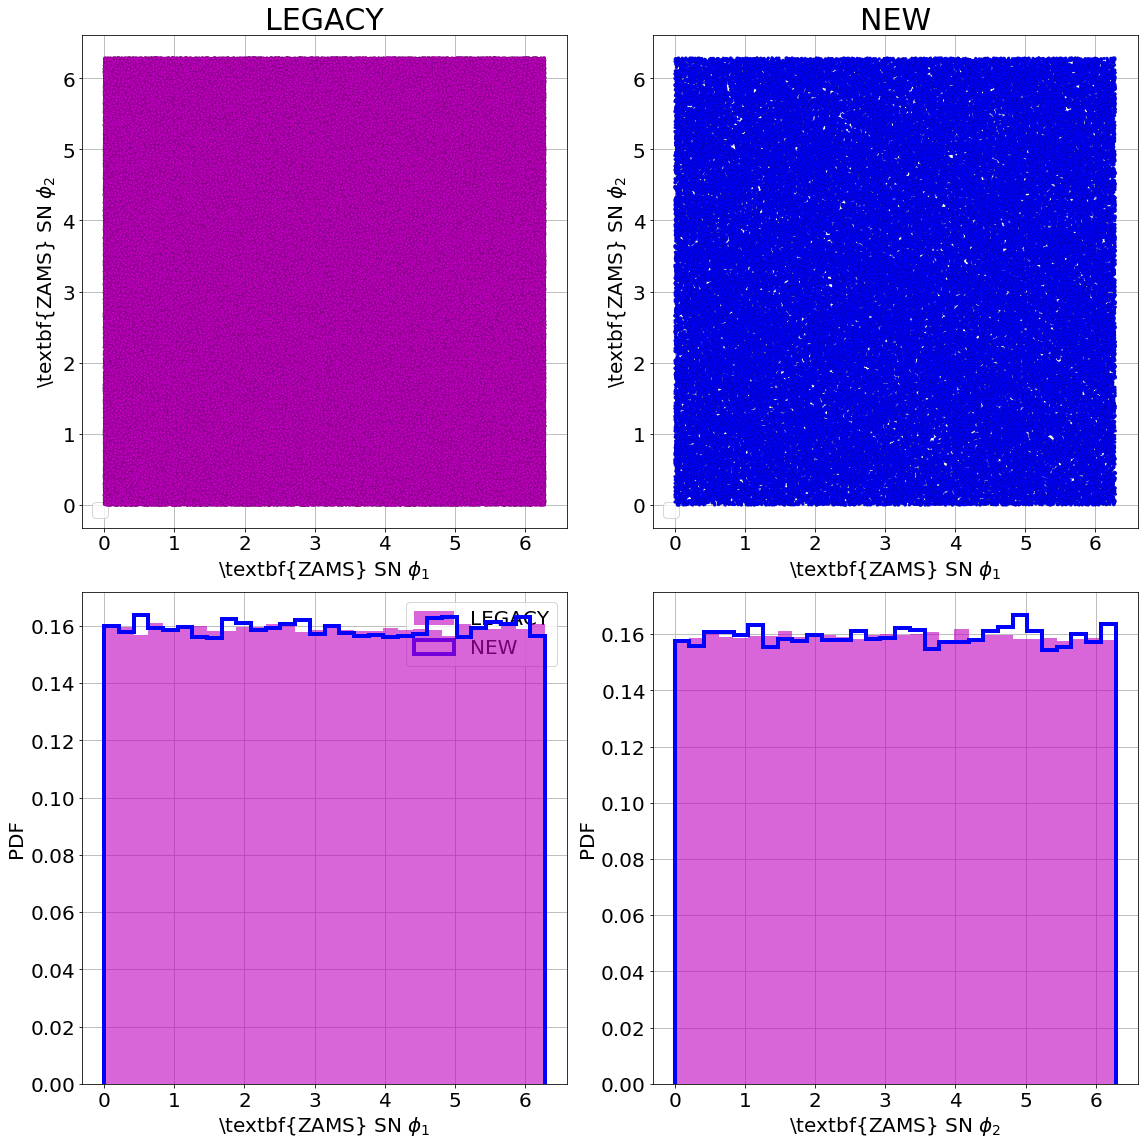

In [11]:


fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)

xvar_leg, yvar_leg = LEG.obtainData(param=['phi1','systems']), LEG.obtainData(param=['phi2','systems'])
# DCOmask_leg = LEG.maskTarget(otherSelection=None, otherparam=None)
DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','SystemParameters'


xvar_new, yvar_new = NEW.obtainData(param=['SN_Phi_1',fparam]), NEW.obtainData(param=['SN_Phi_2',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
DCOweights_new, SystemWeights_new = NEW.obtainweights()




# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'\textbf{ZAMS} SN $\phi_1 $'
ylabel = r'\textbf{ZAMS} SN $\phi_2$' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg, (yvar_leg), SystemWeights_leg]
xyw_newCOMPAS    = [xvar_new, (yvar_new), SystemWeights_new]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[7,25], [7,25]]
xylim= None
COMPASv = '02.03.05'
pltname = 'phi1_phi2_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)







No handles with labels found to put in legend.
No handles with labels found to put in legend.


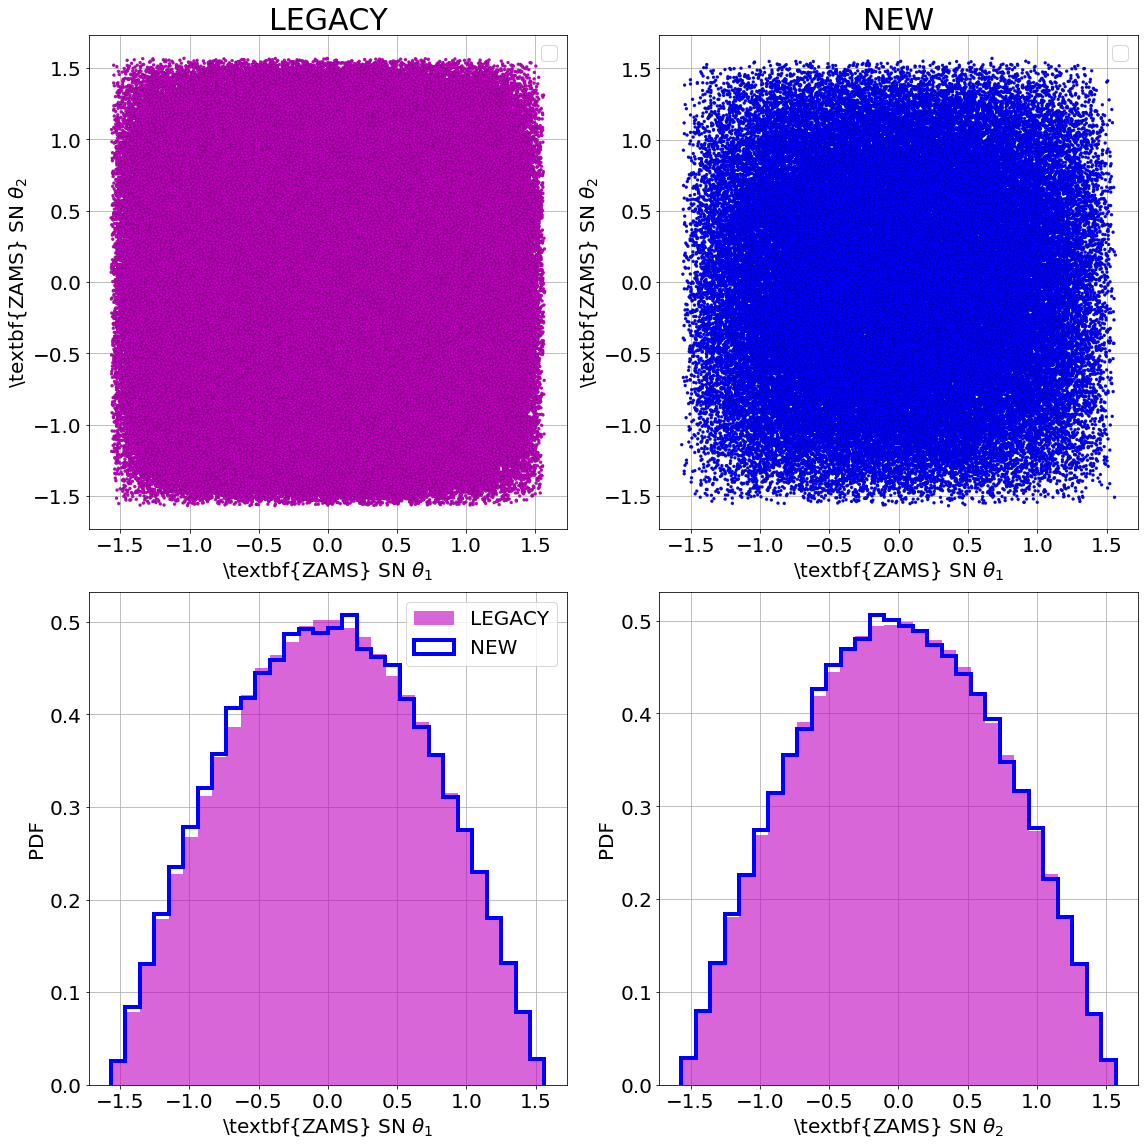

In [13]:


fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)

xvar_leg, yvar_leg = LEG.obtainData(param=['theta1','systems']), LEG.obtainData(param=['theta2','systems'])
# DCOmask_leg = LEG.maskTarget(otherSelection=None, otherparam=None)
DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','SystemParameters'


xvar_new, yvar_new = NEW.obtainData(param=['SN_Theta_1',fparam]), NEW.obtainData(param=['SN_Theta_2',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
DCOweights_new, SystemWeights_new = NEW.obtainweights()




# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'\textbf{ZAMS} SN $\theta_1 $'
ylabel = r'\textbf{ZAMS} SN $\theta_2$' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg, (yvar_leg), SystemWeights_leg]
xyw_newCOMPAS    = [xvar_new, (yvar_new), SystemWeights_new]
xyl_label = [xlabel, ylabel, legendLabel]

# xylim = [[7,25], [7,25]]
# xylim= None
COMPASv = '02.03.05'
pltname = 'theta1_theta2_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)








# SUPERNOVA 1: 

In [14]:
print('--------------- LEGACY ------------------------')
print(fdata_legacy.keys())
print()
print(fdata_legacy['supernovae'].keys())
print()
print()
print(fdata_legacy['supernovae']['RemnantType'][...].squeeze())

#################
print('---------------- NEW -----------------------')
print(fdata_new.keys())
print()
print(fdata_new['Supernovae'].keys())

print(fdata_new['Supernovae']['Stellar_Type_SN'][...].squeeze())
maskNS = (fdata_new['Supernovae']['Stellar_Type_SN'][...].squeeze() ==13)
print(fdata_new['Supernovae']['Stellar_Type_SN'][...].squeeze()[~maskNS])

--------------- LEGACY ------------------------
<KeysViewHDF5 ['RLOF', 'XRayBinaries', 'commonEnvelopes', 'cppSource', 'doubleCompactObjects', 'formationChannels', 'pulsarEvolution', 'runtimes', 'supernovae', 'systems']>

<KeysViewHDF5 ['MCompanionZAMS', 'MSNZAMS', 'MassCOCoreSN', 'MassCoreSN', 'MassStarCompanion', 'MassStarSN', 'Metallicity', 'Mrem', 'RemnantType', 'Survived', 'commonEnvelopeOccuredAtLeastOnce', 'drawnKickVelocity', 'eccentricityAfter', 'eccentricityBefore', 'experiencedRLOF', 'fallback', 'flagECSN', 'flagHpoorSN', 'flagHrichSN', 'flagPISN', 'flagPPISN', 'flagRLOFontoaNS', 'flagSN', 'flagUSSN', 'kickVelocity', 'm_stableRLOFafterCEE', 'phi', 'previousStellarTypeCompanion', 'previousStellarTypeSN', 'psi', 'randomSeed', 'runawayFlag', 'separationAfter', 'separationBefore', 'systemicVelocity', 'theta', 'time', 'uK', 'vRel', 'whichStar']>


[13 14 14 ... 13 13 13]
---------------- NEW -----------------------
<KeysViewHDF5 ['CommonEnvelopes', 'DoubleCompactObjects', 'RLOF',

No handles with labels found to put in legend.
No handles with labels found to put in legend.


LEGACY:
[ 9.4786  19.8368  17.0639  ...  3.37682  5.22911  8.19741]
1.44 92.3415

NEW:
[ 1.277584  1.277584 17.54612  ...  2.256424 16.60853  21.14746 ]
0.0 39.54294



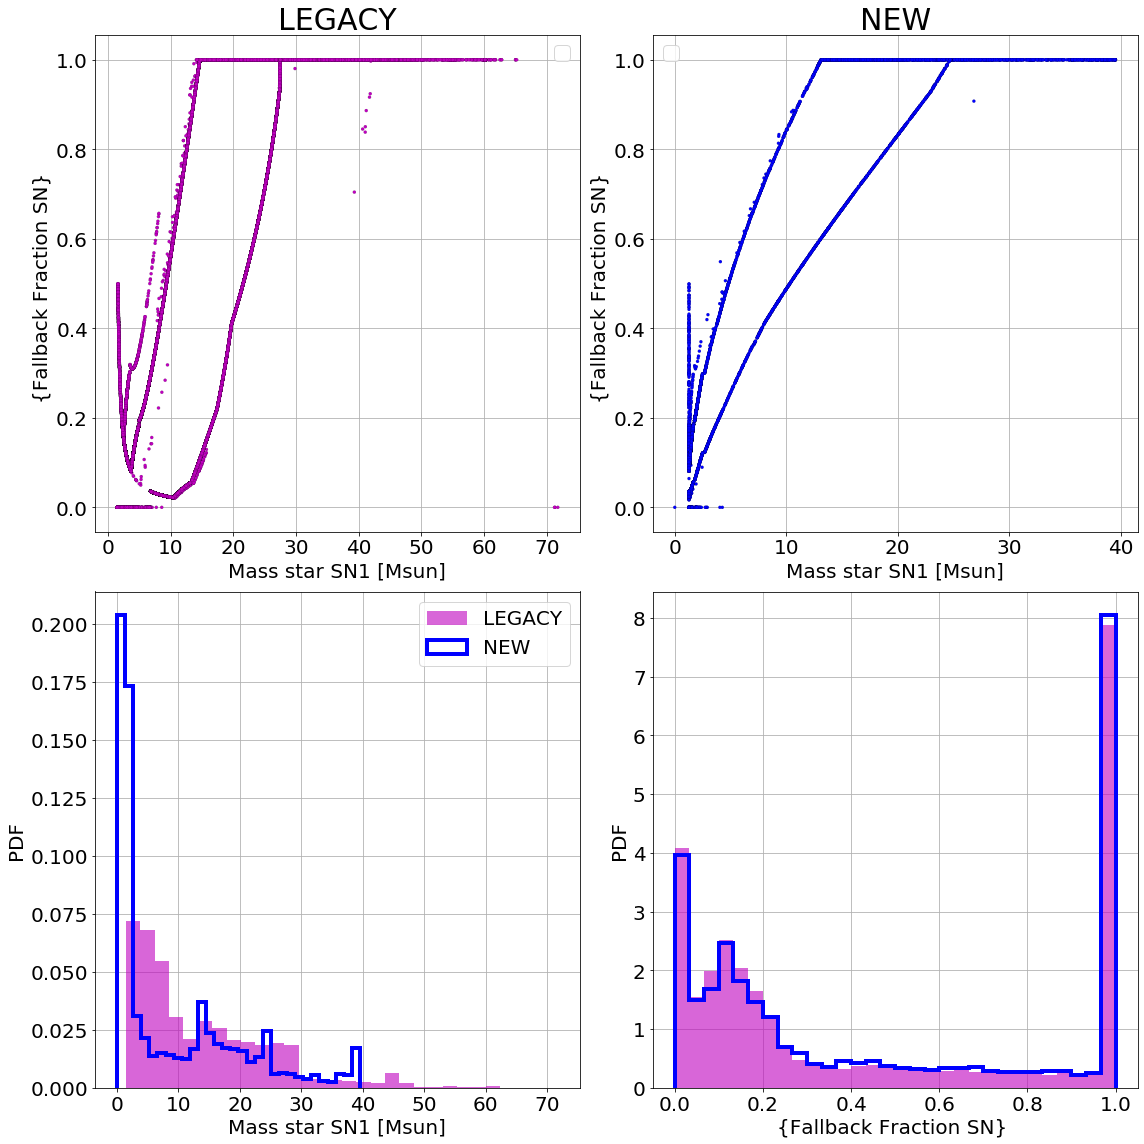

In [44]:




fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)


whichSN_leg, _ = LEG.obtainData(param=['whichStar','supernovae']), LEG.obtainData(param=['whichStar','supernovae'])
xvar_leg, yvar_leg = LEG.obtainData(param=['MassStarSN','supernovae']), LEG.obtainData(param=['fallback','supernovae'])
DCOmask_leg = (whichSN_leg ==2)
# DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
print('LEGACY:')
print(xvar_leg)
print(min(xvar_leg), max(xvar_leg))
print()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = _,'Supernovae'

whichSN_new, _ = NEW.obtainData(param=['Supernova_State',fparam]), NEW.obtainData(param=['Supernova_State',fparam])
xvar_new, yvar_new = NEW.obtainData(param=['Mass_SN',fparam]), NEW.obtainData(param=['Fallback_Fraction_SN',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
# DCOweights_new, SystemWeights_new = NEW.obtainweights()
DCOmask_new = (whichSN_new ==2)
print('NEW:')
print(xvar_new)
print(min(xvar_new), max(xvar_new))
print()
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'Mass star SN1 [Msun]'
ylabel = r'{Fallback Fraction SN} ' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg[DCOmask_leg], (yvar_leg[DCOmask_leg]), np.ones_like(xvar_leg[DCOmask_leg])]
xyw_newCOMPAS    = [xvar_new[DCOmask_new], (yvar_new[DCOmask_new]), np.ones_like(xvar_new[DCOmask_new])]
xyl_label = [xlabel, ylabel, legendLabel]

# xylim = [[1,1300], [1,1300]]
xylim= None

pltname = fparam + '_Mass_fallback_' +  '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)








No handles with labels found to put in legend.
No handles with labels found to put in legend.


{1, 2, 4, 8, 16}
NOT SURE IF THESE ARE THE RIGHT INDICES?


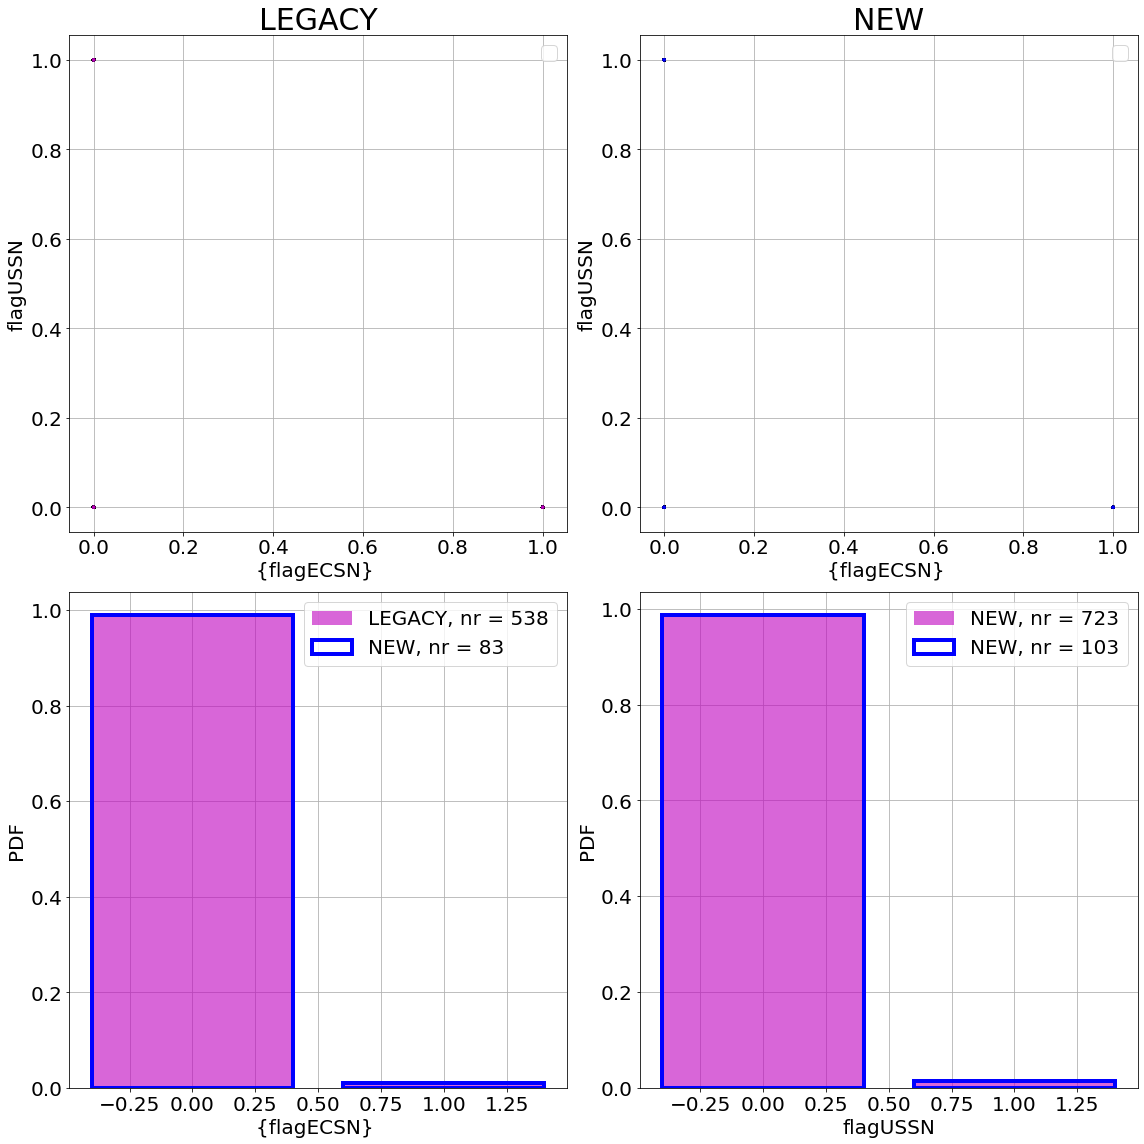

In [26]:
def plotBoolLegacyVSnewCOMPAS(xyw_legacy, xyw_new, xyl_label, xylim, plotname):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    fs = 20
    
    
    xparam = [xyw_legacy[0], xyw_new[0]]
    yparam = [xyw_legacy[1], xyw_new[1]]
    weights= [xyw_legacy[2], xyw_new[2]]

    
    xlabel, ylabel, legendlabel = xyl_label
    titles = ['LEGACY', 'NEW']
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    
    
    
    f, ax= plt.subplots(ncols=2, nrows=2, figsize=(16,16)) #,   gridspec_kw={"width_ratios":[1.5, 1.5]}




    
    
    
    for z_ind in range(2):
        

        colorr = ['m', 'b']

        ax[0, z_ind].scatter(xparam[z_ind], yparam[z_ind], s=weights[z_ind]*10 , edgecolor ='k', linewidth=0.1,\
                         c=colorr[z_ind], label =legendlabel, zorder=10)




        ax[0, z_ind].set_ylabel(ylabel, fontsize=fs)
        ax[0, z_ind].set_xlabel(xlabel, fontsize=fs)
        ax[0, z_ind].set_title(titles[z_ind], fontsize=fs+10)
        ax[0, z_ind].legend(fontsize=fs)

        ax[0, z_ind].tick_params(labelsize=fs)
        ax[0, z_ind].grid(True, which='major');
        
        if xylim:
            ax[0, z_ind].set_xlim(xylim[0][0], xylim[0][1])
            ax[0, z_ind].set_ylim(xylim[1][0], xylim[1][1])


            

        bins = 30
        
#         ####################   
#         #### X param hist # 
        if z_ind==0:
#             if xylim:
#                 bins = np.linspace(xylim[0][0], xylim[0][1], 40)
#                 ax[1, z_ind].set_xlim(xylim[0][0], xylim[0][1])
            

            NxparamTrue = np.sum(xparam[0]) / len(xparam[0])
            NxparamFalse = (len(xparam[0]) - np.sum(xparam[0]))/ len(xparam[0])
            NyparamTrue = (np.sum(yparam[0]))/  len(xparam[0])
            NyparamFalse = (len(yparam[0]) - np.sum(yparam[0]) )  / len(xparam[0])
            
#             print(np.sum(xparam[0]), len(xparam[0]), NxparamTrue)
            ax[1, z_ind].bar(1, NxparamTrue, \
                            color=colorr[0], zorder=10, alpha=0.6, label='%s, nr = %s'%(titles[0], np.sum(xparam[0])))
            ax[1, z_ind].bar(0, NxparamFalse, \
                            color=colorr[0], zorder=10, alpha=0.6)
            
            ax[1,1].bar(1, NyparamTrue, label='%s, nr = %s'%(titles[1], np.sum(yparam[0])),\
                            color=colorr[0], zorder=10, alpha=0.6)
            ax[1,1].bar(0, NyparamFalse, \
                            color=colorr[0], zorder=10, alpha=0.6)
            
            
            NxparamTrue = np.sum(xparam[1]) / len(xparam[1])
            NxparamFalse = (len(xparam[1]) - np.sum(xparam[1]))/ len(xparam[1])
            NyparamTrue = (np.sum(yparam[1]))/  len(xparam[1])
            NyparamFalse = (len(yparam[1]) - np.sum(yparam[1]) )  / len(yparam[1])
            

            ax[1, z_ind].bar(1, NxparamTrue, \
                            color='',edgecolor=colorr[1], zorder=20, alpha=1, label='%s, nr = %s'%(titles[1],np.sum(xparam[1])), linewidth=4)
            ax[1, z_ind].bar(0, NxparamFalse, \
                            color='',edgecolor=colorr[1], zorder=20, alpha=1, linewidth=4)  \
            
            ax[1, 1].bar(1, NyparamTrue, \
                            color='',edgecolor=colorr[1], zorder=20, alpha=1, label='%s, nr = %s'%(titles[1],np.sum(yparam[1])), linewidth=4)
            ax[1, 1].bar(0, NyparamFalse, \
                            color='',edgecolor=colorr[1], zorder=20, alpha=1, linewidth=4) 
            
            
            
#                              color=colorr[0], zorder=10, alpha=0.6, label=titles[0])
#             ax[1, z_ind].hist(xparam[1], bins=bins, histtype='step', density=True,\
#                              color=colorr[1], zorder=20, alpha=1, lw=4, label=titles[1])
            
            
            ax[1, z_ind].legend(fontsize=fs)
            
            ax[1, z_ind].set_ylabel('PDF', fontsize=fs)
            ax[1, 0].set_xlabel(xlabel, fontsize=fs)
            ax[1, z_ind].tick_params(labelsize=fs)
            ax[1, z_ind].grid(True, which='major');

            ax[1, 1].set_ylabel('PDF', fontsize=fs)
            ax[1, 1].set_xlabel(ylabel, fontsize=fs)
            ax[1, 1].tick_params(labelsize=fs)
            ax[1, 1].grid(True, which='major');            
            ax[1, 1].legend(fontsize=fs)
            
#         if z_ind==1:
#             ####################   
#             #### Y param hist # 
#             if xylim:
#                 bins =  np.linspace(xylim[1][0], xylim[1][1], 40)
#                 ax[1, z_ind].set_xlim(xylim[1][0], xylim[1][1])

#             ax[1, z_ind].hist(yparam[0], bins=bins, density=True,\
#                              color=colorr[0], zorder=10, alpha=0.6)
#             ax[1, z_ind].hist(yparam[1], bins=bins, histtype='step', density=True,\
#                              color=colorr[1], zorder=20, alpha=1, lw=4)
            
            
#             ax[1, z_ind].set_ylabel('PDF', fontsize=fs)
#             ax[1, z_ind].set_xlabel(ylabel, fontsize=fs)
#             ax[1, z_ind].tick_params(labelsize=fs)
#             ax[1, z_ind].grid(True, which='major');
        
        

        

            
    f.tight_layout()
    f.savefig('./images/'+ plotname +'.png') #, bbox_extra_artists=(lgd,), bbox_inches='tight'
    plt.show()
    plt.close() 
        
        
    return 






fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)


whichSN_leg, _ = LEG.obtainData(param=['whichStar','supernovae']), LEG.obtainData(param=['whichStar','supernovae'])
xvar_leg, yvar_leg = LEG.obtainData(param=['flagECSN','supernovae']), LEG.obtainData(param=['flagUSSN','supernovae'])
DCOmask_leg = (whichSN_leg ==2)
# DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','Supernovae'

whichSN_new, _ = NEW.obtainData(param=['Supernova_State',fparam]), NEW.obtainData(param=['Supernova_State',fparam])
xvar_new, yvar_new = NEW.obtainData(param=['SN_Type_SN',fparam]), NEW.obtainData(param=['SN_Type_SN',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
# DCOweights_new, SystemWeights_new = NEW.obtainweights()
DCOmask_new = (whichSN_new ==2)

print(set(xvar_new))
print('NOT SURE IF THESE ARE THE RIGHT INDICES?')
xvar_new = (xvar_new==2)  # ECSN ????? 
yvar_new = (yvar_new==16) ## USSN ???? NOT SURE

# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'{flagECSN} '
ylabel = r'flagUSSN' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg[DCOmask_leg], (yvar_leg[DCOmask_leg]), np.ones_like(xvar_leg[DCOmask_leg])]
xyw_newCOMPAS    = [xvar_new[DCOmask_new], (yvar_new[DCOmask_new]), np.ones_like(xvar_new[DCOmask_new])]
xyl_label = [xlabel, ylabel, legendLabel]

# xylim = [[1,1300], [1,1300]]
xylim= None
COMPASv = '02.03.05'
pltname = 'ECSN_USSN_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotBoolLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)








No handles with labels found to put in legend.
No handles with labels found to put in legend.


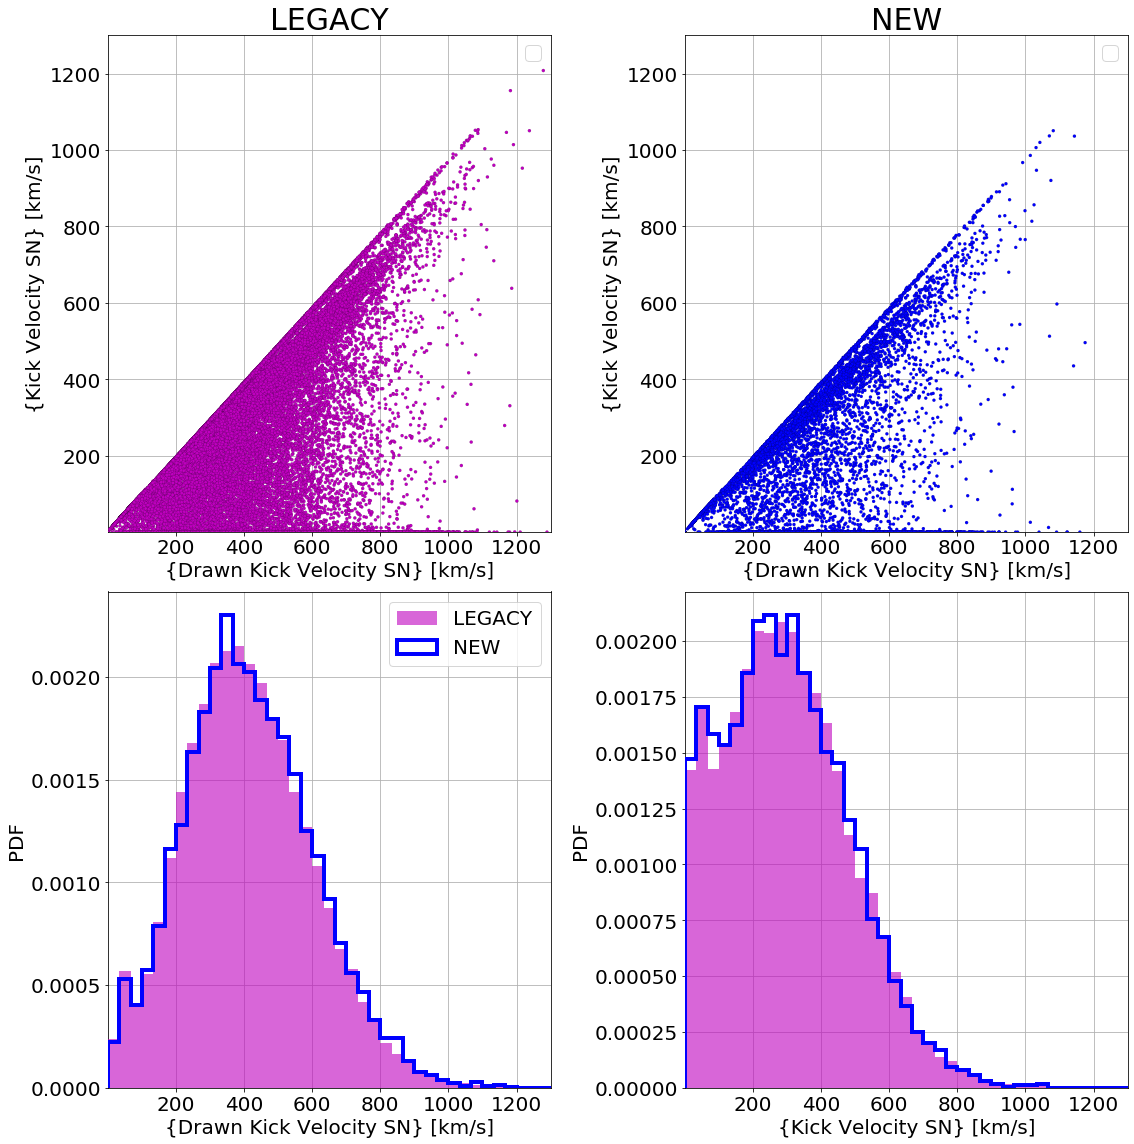

In [27]:




fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)


whichSN_leg, _ = LEG.obtainData(param=['whichStar','supernovae']), LEG.obtainData(param=['whichStar','supernovae'])
xvar_leg, yvar_leg = LEG.obtainData(param=['drawnKickVelocity','supernovae']), LEG.obtainData(param=['kickVelocity','supernovae'])
DCOmask_leg = (whichSN_leg ==2)
# DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','Supernovae'

whichSN_new, _ = NEW.obtainData(param=['Supernova_State',fparam]), NEW.obtainData(param=['Supernova_State',fparam])
xvar_new, yvar_new = NEW.obtainData(param=['Drawn_Kick_Velocity_SN',fparam]), NEW.obtainData(param=['Kick_Velocity_SN',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
# DCOweights_new, SystemWeights_new = NEW.obtainweights()
DCOmask_new = (whichSN_new ==2)



# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'{Drawn Kick Velocity SN} [km/s]'
ylabel = r'{Kick Velocity SN} [km/s]' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg[DCOmask_leg], (yvar_leg[DCOmask_leg]), np.ones_like(xvar_leg[DCOmask_leg])]
xyw_newCOMPAS    = [xvar_new[DCOmask_new], (yvar_new[DCOmask_new]), np.ones_like(xvar_new[DCOmask_new])]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[1,1300], [1,1300]]
# xylim= None
COMPASv = '02.03.05'
pltname = 'SN2_kick_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)







No handles with labels found to put in legend.
No handles with labels found to put in legend.


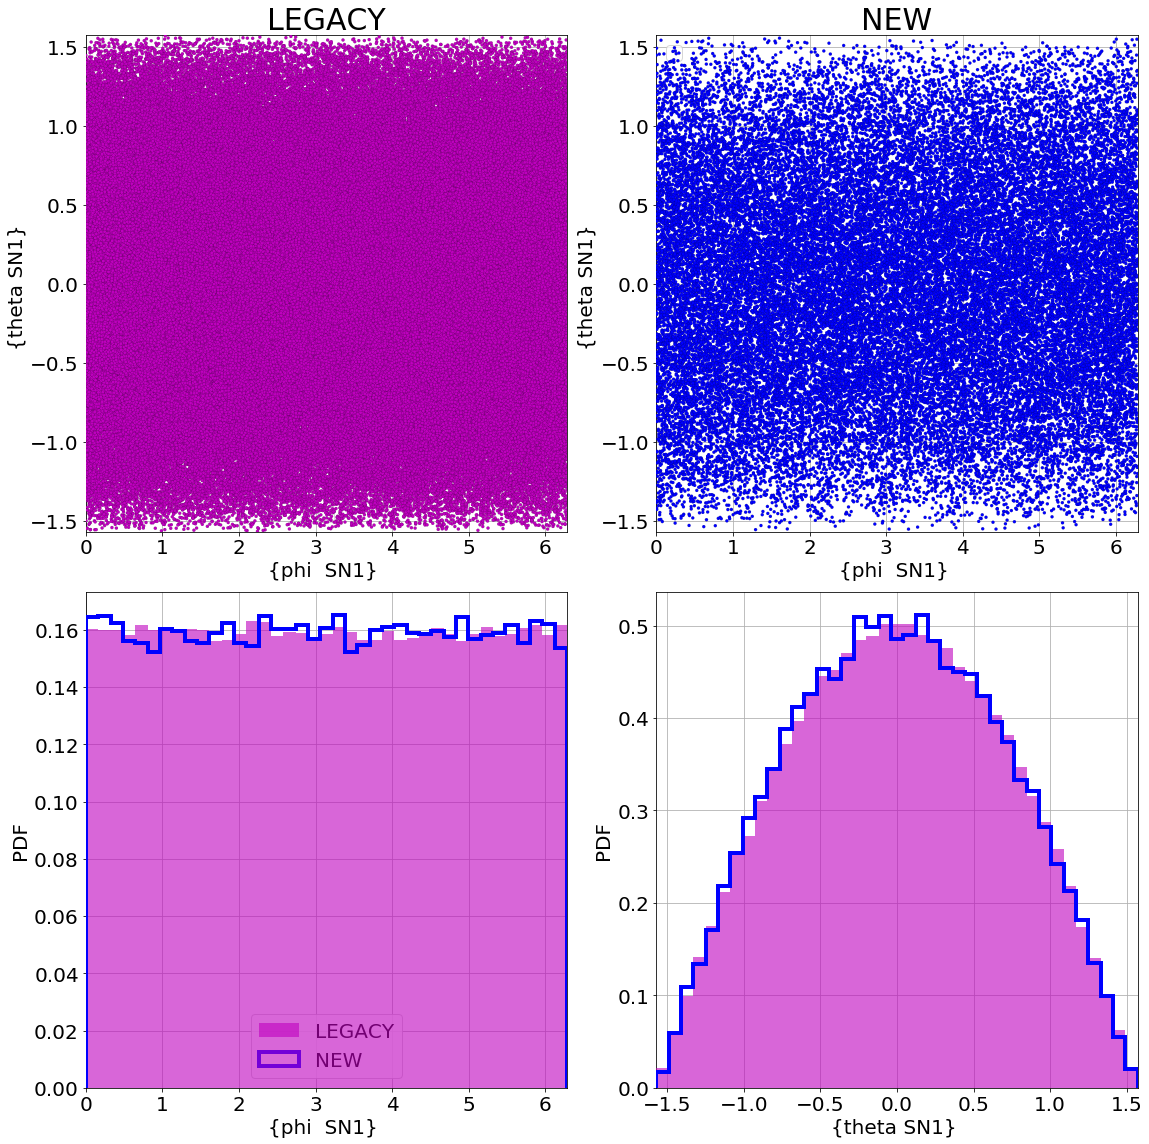

In [28]:





fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)


whichSN_leg, _ = LEG.obtainData(param=['whichStar','supernovae']), LEG.obtainData(param=['whichStar','supernovae'])
xvar_leg, yvar_leg = LEG.obtainData(param=['phi','supernovae']), LEG.obtainData(param=['theta','supernovae'])
DCOmask_leg = (whichSN_leg ==1)
# DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','Supernovae'

whichSN_new, _ = NEW.obtainData(param=['Supernova_State',fparam]), NEW.obtainData(param=['Supernova_State',fparam])
xvar_new, yvar_new = NEW.obtainData(param=['SN_Phi_SN',fparam]), NEW.obtainData(param=['SN_Theta_SN',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
# DCOweights_new, SystemWeights_new = NEW.obtainweights()
DCOmask_new = (whichSN_new ==1)



# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'{phi  SN1} '
ylabel = r'{theta SN1} ' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg[DCOmask_leg], (yvar_leg[DCOmask_leg]), np.ones_like(xvar_leg[DCOmask_leg])]
xyw_newCOMPAS    = [xvar_new[DCOmask_new], (yvar_new[DCOmask_new]), np.ones_like(xvar_new[DCOmask_new])]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[0,2*np.pi], [-np.pi/2, np.pi/2]]
# xylim= None
COMPASv = '02.03.05'
pltname = 'phi_theta_SN1_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)








No handles with labels found to put in legend.
No handles with labels found to put in legend.


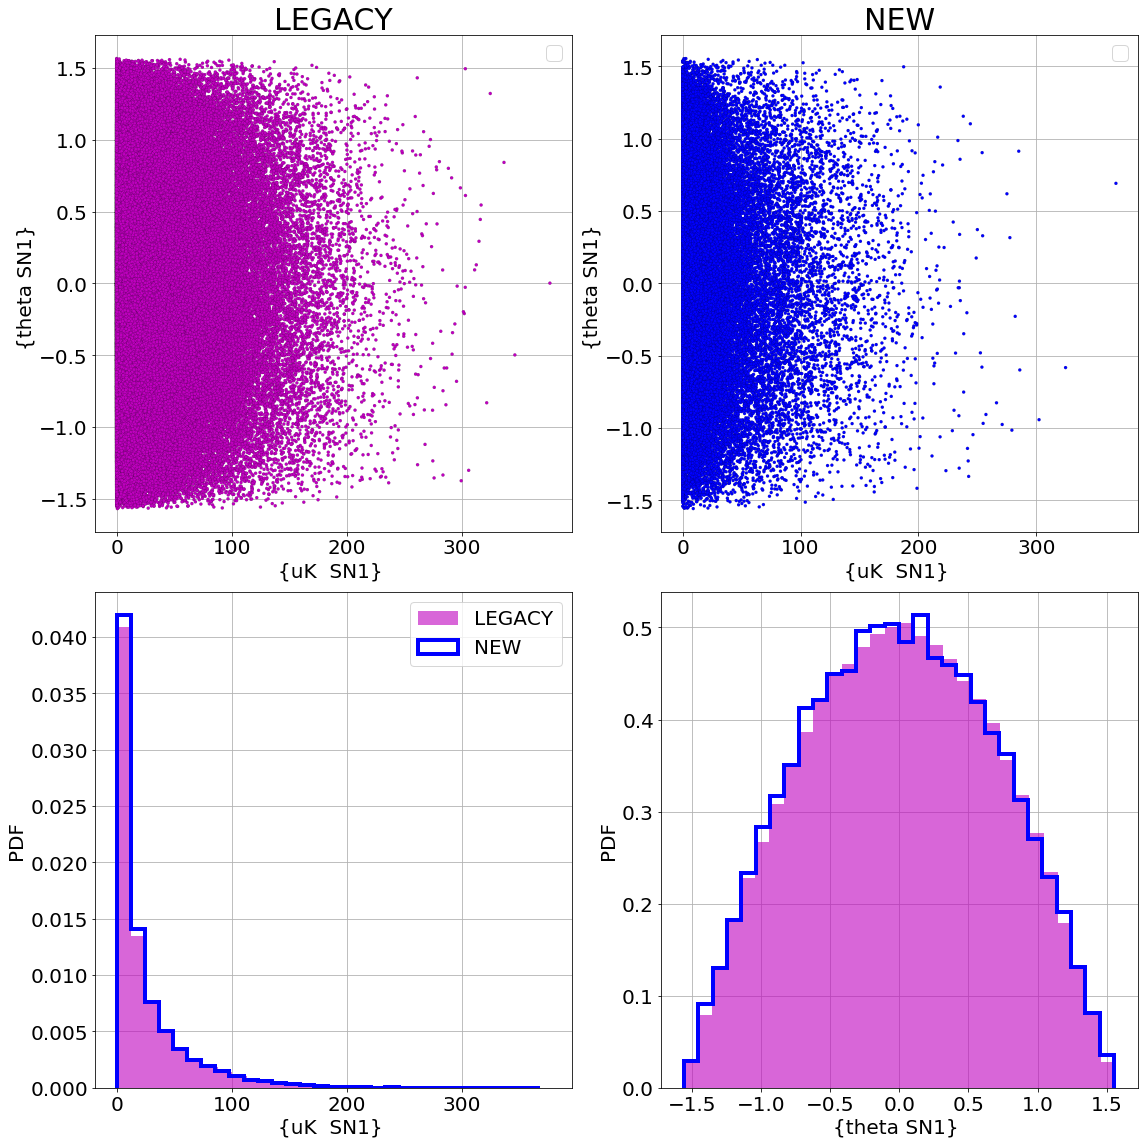

In [29]:





fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = ''

# LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
# NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)


whichSN_leg, _ = LEG.obtainData(param=['whichStar','supernovae']), LEG.obtainData(param=['whichStar','supernovae'])
xvar_leg, yvar_leg = LEG.obtainData(param=['uK','supernovae']), LEG.obtainData(param=['theta','supernovae'])
DCOmask_leg = (whichSN_leg ==1)
# DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
# print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))


xparam, fparam = 'MZAMS_1','Supernovae'

whichSN_new, _ = NEW.obtainData(param=['Supernova_State',fparam]), NEW.obtainData(param=['Supernova_State',fparam])
xvar_new, yvar_new = NEW.obtainData(param=['Kick_Velocity(uK)',fparam]), NEW.obtainData(param=['SN_Theta_SN',fparam])
# DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
# DCOweights_new, SystemWeights_new = NEW.obtainweights()
DCOmask_new = (whichSN_new ==1)



# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'{uK  SN1} '
ylabel = r'{theta SN1} ' # [\rm{M}_{\odot}]
legendLabel = dcotype #+ ' mergers'


xyw_legacyCOMPAS = [xvar_leg[DCOmask_leg], (yvar_leg[DCOmask_leg]), np.ones_like(xvar_leg[DCOmask_leg])]
xyw_newCOMPAS    = [xvar_new[DCOmask_new], (yvar_new[DCOmask_new]), np.ones_like(xvar_new[DCOmask_new])]
xyl_label = [xlabel, ylabel, legendLabel]

# xylim = [[0,2*np.pi], [-np.pi/2, np.pi/2]]
xylim= None
COMPASv = '02.03.05'
pltname = 'uK_theta_SN1_' + fparam + '_Z' + str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)









# 3. Check DCOs parameters

# ZAMS MASSES

In [37]:


fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = 'BHNS'

LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)

M1ZAMS_leg, M2ZAMS_leg = LEG.obtainData(param=['M1ZAMS','doubleCompactObjects']), LEG.obtainData(param=['M2ZAMS','doubleCompactObjects'])
DCOmask_leg = LEG.maskTarget(otherSelection=None, otherparam=None)
DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))

M1ZAMS_new, M2ZAMS_new = NEW.obtainData(param=['MZAMS_1','DoubleCompactObjects']), NEW.obtainData(param=['MZAMS_2','DoubleCompactObjects'])
DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
DCOweights_new, SystemWeights_new = NEW.obtainweights()

print(len(SystemWeights_new))
print('# =', np.sum(DCOweights_new[DCOmask_new])/len(SystemWeights_new))
# print('# =', len(DCOweights_new))

mask sums =  1016 16321 16321 16321
# = 0.0016933276889077036
mask sums =  134 2462 2462 2462
100000
# = 0.00134


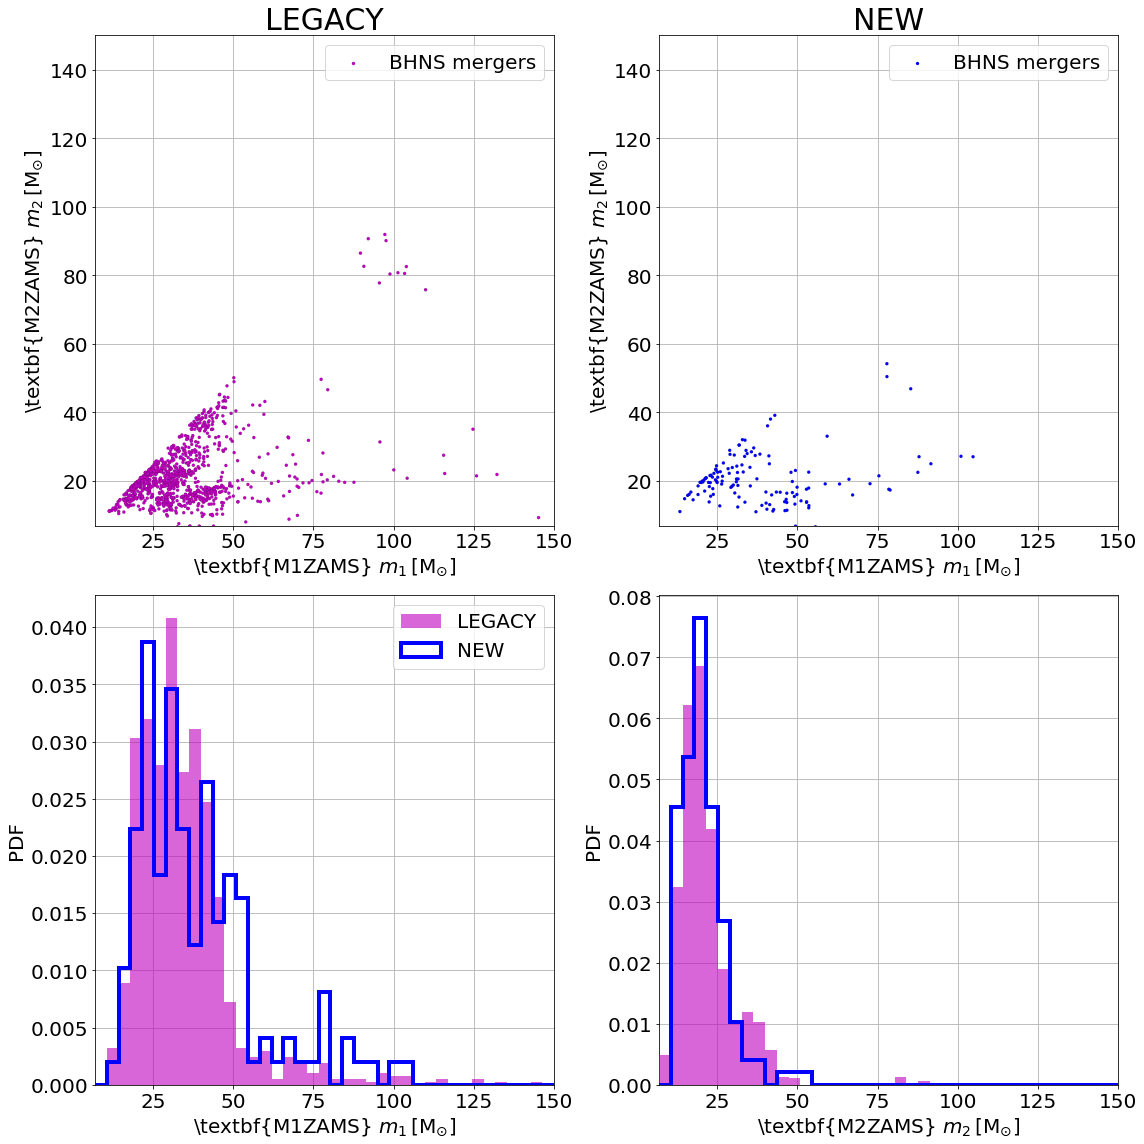

In [38]:
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'\textbf{M1ZAMS} $m_{1} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{M2ZAMS} $m_{2} \, [\rm{M}_{\odot}]$'
legendLabel = dcotype + ' mergers'


xyw_legacyCOMPAS = [M1ZAMS_leg[DCOmask_leg], M2ZAMS_leg[DCOmask_leg], DCOweights_leg[DCOmask_leg]]
xyw_newCOMPAS = [M1ZAMS_new[DCOmask_new], M2ZAMS_new[DCOmask_new], DCOweights_new[DCOmask_new]]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[7,150], [7,150]]

COMPASv = '02.03.05'
pltname = 'ZAMS_' +  '_Z' + '_BHNS_'+ str(Z) + '__compas_' +COMPASv 

plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)




# DCO MASSES

mask sums =  715 16321 16321 16321
# = 0.0011916626944576852
mask sums =  59 2462 2462 2462
100000
# = 0.00059


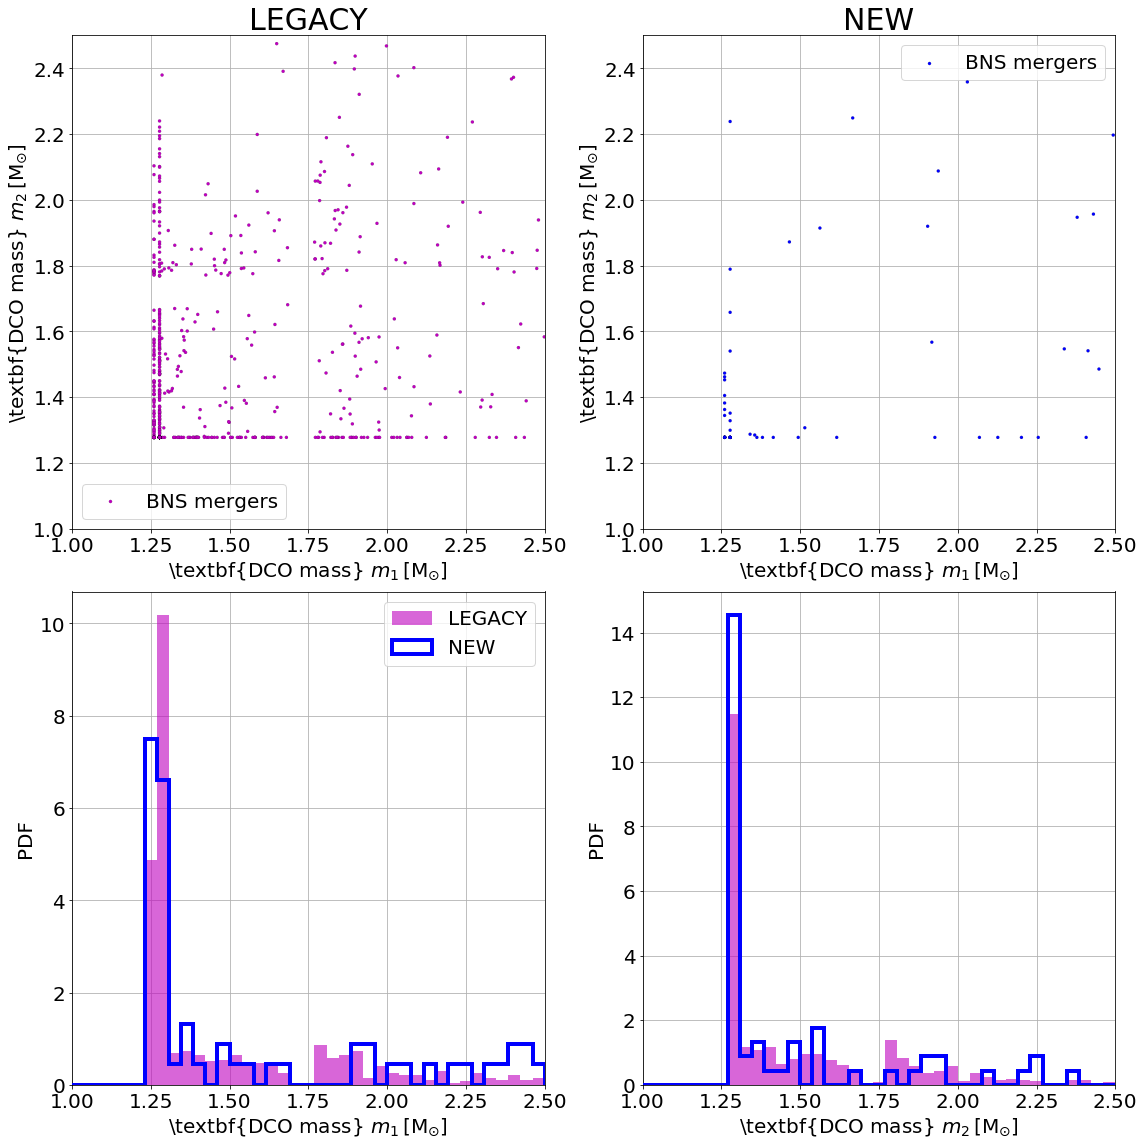

In [45]:


fdata_legacy = h5.File(path_legacy)
fdata_new = h5.File(path_new)
Z = 0.001

boolmask=[0,0,0]
dcotype = 'BNS'

LEG = LegacyVSnewCOMPAS(hdf5=fdata_legacy, whichCOMPAS='legacy', metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)
NEW = LegacyVSnewCOMPAS(hdf5=fdata_new,    whichCOMPAS='new',    metallicity=Z, DCOtype=dcotype, boolDCOmask=boolmask)

M1ZAMS_leg, M2ZAMS_leg = LEG.obtainData(param=['M1','doubleCompactObjects']), LEG.obtainData(param=['M2','doubleCompactObjects'])
DCOmask_leg = LEG.maskTarget(otherSelection=None, otherparam=None)
DCOweights_leg, SystemWeights_leg = LEG.obtainweights()
print('# =', np.sum(DCOweights_leg[DCOmask_leg])/len(SystemWeights_leg))

M1ZAMS_new, M2ZAMS_new = NEW.obtainData(param=['Mass_1','DoubleCompactObjects']), NEW.obtainData(param=['Mass_2','DoubleCompactObjects'])
DCOmask_new = NEW.maskTarget(otherSelection=None, otherparam=None)
DCOweights_new, SystemWeights_new = NEW.obtainweights()

print(len(SystemWeights_new))
print('# =', np.sum(DCOweights_new[DCOmask_new])/len(SystemWeights_new))
# print('# =', len(DCOweights_new))






# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
xlabel = r'\textbf{DCO mass} $m_{1} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{DCO mass} $m_{2} \, [\rm{M}_{\odot}]$'
legendLabel = dcotype + ' mergers'


xyw_legacyCOMPAS = [M1ZAMS_leg[DCOmask_leg], M2ZAMS_leg[DCOmask_leg], DCOweights_leg[DCOmask_leg]]
xyw_newCOMPAS = [M1ZAMS_new[DCOmask_new], M2ZAMS_new[DCOmask_new], DCOweights_new[DCOmask_new]]
xyl_label = [xlabel, ylabel, legendLabel]

xylim = [[1,2.5], [1,2.5]]
# xylim = None

pltname = 'DCO_' +  '_Z' + str(Z) +dcotype + '__compas_' +COMPASv 
# pltname = 'DCO_' +  '_Z' + '_BNS_'+ str(Z) + '__compas_' +COMPASv 
plotLegacyVSnewCOMPAS(xyw_legacy=xyw_legacyCOMPAS, \
                      xyw_new=xyw_newCOMPAS, xyl_label=xyl_label, xylim = xylim, plotname=pltname)



